# Tutorial 07 – Advanced Preprocessing and Validation

In this tutorial we will look at how to select subset of features and not hurt the model performance, how to use PCA as for feature engineering and how to validate your model.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set()  # make plots nicer

## Feature Selection

The goal of feature selection is to identify important features and select only those for model training. Feature selection can serve two purposes:
1. Reducing the data and model size and speeding up computation. This is not a problem for simple model we are dealing with but it might be important to deliver everything on time in production environment.
2. Improving model performance. While not all models will benefit from this it can happen that models will perform better with fewer features. This is often the case for correlated features with duplicate information. Also model relying on distance computation might benefit from fewer features.

Let's load titanic data and see how feature selection will affect KNN classifier.

In [3]:
titanic = sns.load_dataset("titanic")
# drop redundant columns
titanic = titanic.drop(columns=["embarked", "who", "class", "alive"])
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,adult_male,deck,embark_town,alone
0,0,3,male,22.0,1,0,7.2500,True,NaN,Southampton,False
1,1,1,female,38.0,1,0,71.2833,False,C,Cherbourg,False
2,1,3,female,26.0,0,0,7.9250,False,NaN,Southampton,True
3,1,1,female,35.0,1,0,53.1000,False,C,Southampton,False
4,0,3,male,35.0,0,0,8.0500,True,NaN,Southampton,True


In [4]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   adult_male   891 non-null    bool    
 8   deck         203 non-null    category
 9   embark_town  889 non-null    object  
 10  alone        891 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(2)
memory usage: 58.8+ KB


There are features with missing values. Unfortunately, there is no simple way of imputing categorical features as encoder require all data to be present and KNN imputer cannot impute categorical data. Therefore, let's just create a new category for missing values.

In [5]:
titanic["deck"] = titanic.deck.cat.add_categories("missing")
titanic["deck"] = titanic.deck.fillna("missing")
titanic["embark_town"] = titanic.embark_town.fillna("missing")
titanic["embark_town"] = titanic.embark_town.astype("category")

In [6]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   adult_male   891 non-null    bool    
 8   deck         891 non-null    category
 9   embark_town  891 non-null    category
 10  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(1)
memory usage: 52.9+ KB


Now we still have some missing ages in the data that will need to be imputed. Let's create train and test set and prepare pipeline.

In [7]:
from sklearn.model_selection import train_test_split

titanic_X, titanic_y = titanic.drop(columns="survived"), titanic.survived

titanic_train_X, titanic_test_X, titanic_train_y, titanic_test_y = train_test_split(
    titanic_X, titanic_y, test_size=0.2, random_state=42
)

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.compose import make_column_transformer, make_column_selector

knn_pipeline = make_pipeline(
    make_column_transformer(
        (OrdinalEncoder(), ["sex"]),
        (OneHotEncoder(), ["deck", "embark_town"]),
        remainder="passthrough",
    ),
    KNNImputer(),
    MinMaxScaler(),
    KNeighborsClassifier(),
)

knn_pipeline.fit(titanic_train_X, titanic_train_y)
round(knn_pipeline.score(titanic_test_X, titanic_test_y), 2)

0.8

<div class="alert alert-block alert-warning"><b>Exercise 1</b></div>

Modify the `knn_pipeline` by adding feature selection in form of selecting only few 'most useful' features. This can be achieved using [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) class from `scikit-learn`. For this exercise, let's set $k = 8$, i.e., select 8 'most useful' features, and compute score on test set.

You should obtain accuracy of $0.82$.

In [9]:
# TODO: your code goes here...
from sklearn.feature_selection import SelectKBest

knn_pipeline_two = make_pipeline(
    knn_pipeline[:2],
    SelectKBest(k=8),
    knn_pipeline[2:]
)

knn_pipeline_two.fit(titanic_train_X, titanic_train_y)
round(knn_pipeline_two.score(titanic_test_X, titanic_test_y), 2)

0.82

Of course, setting $k=8$ is a bit arbitrary. Ideally, we would like to have some supporting evidence for choosing a specific value of $k$. One way is to test all possible values of $k$ and see which one maximizes the score. It is not that straight forward, though. Optimizing score of a classifier on test data could lead to over-fitting on test data. Generally, we want the model to perform well on test data but even test data is just a small sample of the whole reality and specifically tailoring the model to specific test data will not give good estimates on how the model will perform on completely new and unseen data.

We need to do an intermediate step and put aside part of training data for so called validation. This validation dataset is not accessible to the model during training but we can use it for tuning parameters. In this case changing $k$ to maximize model's performance on unseen data. Test data is then used to give estimate on model performance on new data that the model might encounter in the wild.

<div class="alert alert-block alert-warning"><b>Exercise 2</b></div>

Use `train_test_split` function to set aside 20 % of training data as validation data. Use `random_state=42` for reproducibility.

In [10]:
# TODO: titanic_train_X, titanic_validation_X, titanic_train_y, titanic_validation_y = your code goes here...
titanic_train_X, titanic_validation_X, titanic_train_y, titanic_validation_y = train_test_split(
    titanic_train_X, titanic_train_y, test_size=0.2, random_state=42
)

<div class="alert alert-block alert-warning"><b>Exercise 3</b></div>

Compute score of KNN classifier for all possible values of $k$ on validation data set, print the best $k$ and `score` and plot the relation between $k$ and `score`.

The best score on validation dataset should be $0.86$ and the plot should look similar to [this one](https://www.fi.muni.cz/~xcechak1/IB031/assets/titanic_knn_select.png).

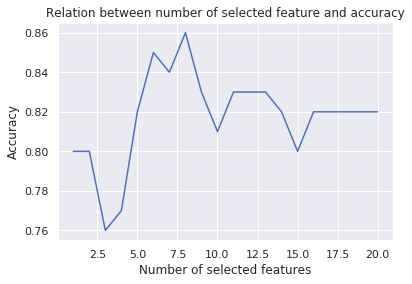

k:8 0.86


In [11]:
# TODO: you code goes here...
results = dict()
for i in range(1, 21):
    knn_pipeline_test = make_pipeline(
        knn_pipeline[:2],
        SelectKBest(k=i),
        knn_pipeline[2:]
    )

    knn_pipeline_test.fit(titanic_train_X, titanic_train_y)
    results[i] = round(knn_pipeline_test.score(titanic_validation_X, titanic_validation_y), 2)

ax = sns.lineplot(
    x = list(results.keys()),
    y = list(results.values())
)
ax.set(
    title = "Relation between number of selected feature and accuracy",
    xlabel = "Number of selected features",
    ylabel = "Accuracy"
)
plt.show()
max_value = max(results.values())
for key, value in results.items(): 
    if value == max_value:
        print(f'k:{key} {value}')

Now that we know that eight features are enough and using only them results in better performing model it is natural to ask "What are those eight features?".

<div class="alert alert-block alert-danger"><b>Exercise 4</b></div>

Find out what features were selected using `SelectKBest` with $k=8$. There is unfortunately not easy way of doing this. You can access boolean index of what features were selected using `get_support` method of `SelectKBest`. Unfortunately, one hot encoding result in bunch of new columns being added and you need to investigate the input `titanic_train_X` values and transformed values to figure out the relationships. **Write the features names as a comment in the cell bellow**.

In [33]:
# TODO: your code goes here...
knn_pipeline_best = make_pipeline(
    make_column_transformer(
        (OrdinalEncoder(), ["sex"]),
        (OneHotEncoder(), ["deck", "embark_town"]),
        remainder="passthrough",
    ),
#    SelectKBest(k=8)
)

best_values = knn_pipeline_best.fit_transform(titanic_train_X, titanic_train_y)
#best_values[-1].get_support()
#I run out of time and was unable to correctly find the features :(

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## Feature engineering

Sometimes it is useful to define new features if the model is not  capable enough (it has high bias). There is no single recipe how to create new features but you can do various combinations of existing features. This can include math operations like multiplying features together, making other linear and non-linear combinations or using domain knowledge like feature `adult_male` in titanic dataset that is engineered from features `sex` and `age`.

One common way is to create embedding of existing features. Commonly used embedding are principal components that are obtained using PCA. Apart from combining features they can also reduce dimensionality of the data if we limit the number of components. Let's load new dataset and test PCA.

In [14]:
sonar = pd.read_csv("https://www.fi.muni.cz/~xcechak1/IB031/datasets/sonar.csv")
sonar.head()

,freq_1,freq_2,freq_3,freq_4,freq_5,freq_6,freq_7,freq_8,freq_9,freq_10,...,freq_52,freq_53,freq_54,freq_55,freq_56,freq_57,freq_58,freq_59,freq_60,label
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,rock
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,rock
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,rock
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,rock
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,rock


The dataset contains strengths of 60 sound frequencies after sonar pulse bouncing of a rock or sea mine. The goal is to classify which object did the sonar pulse bounced of.

In [15]:
sonar_X, sonar_y = sonar.drop(columns="label"), sonar.label

sonar_train_X, sonar_test_X, sonar_train_y, sonar_test_y = train_test_split(
    sonar_X, sonar_y, test_size=0.2, random_state=42
)

Using decision tree classifier right away will result in the following accuracy.

In [16]:
from sklearn.tree import DecisionTreeClassifier

dt_pipeline = make_pipeline(DecisionTreeClassifier(max_depth=3))
dt_pipeline.fit(sonar_train_X, sonar_train_y)
round(dt_pipeline.score(sonar_test_X, sonar_test_y), 2)

0.71

The data has many features but they do not contain that many information. We can improve the model by apply PCA to features.

<div class="alert alert-block alert-warning"><b>Exercise 5</b></div>

Computer first 10 principal component using [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and select 4 best of them using `SelectKBest` and use them to train decision tree.

You should get score of $0.79$ on test set.

In [20]:
# TODO: your code goes here...
knn_pipeline_new.get
from sklearn.decomposition import PCA

dt_pipeline_test = make_pipeline(
    PCA(n_components=10),
    SelectKBest(k=4),
    DecisionTreeClassifier(max_depth=3)
)

dt_pipeline_test.fit(sonar_train_X, sonar_train_y)
round(dt_pipeline_test.score(sonar_test_X, sonar_test_y), 2)

0.79

However, this again smells like over-fitting on test set. Let's use k-fold cross validation to get more reliable estimate of how capable would the classifier be on new data.

<div class="alert alert-block alert-warning"><b>Exercise 6</b></div>

Use [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function to compute **mean accuracy (score) across 10-fold cross validation** on sonar dataset. You can also get 95 % confidence interval as plus/minus two standard deviation on either side of the mean.

If you use pipeline from the previous exercise, you should get mean accuracy 0.70 (+/- 0.15) hinting that result from previous exercise was too optimistic.

In [24]:
# TODO: your code goes here...
from sklearn.model_selection import cross_val_score

cross_val_score(dt_pipeline_test, sonar_X, sonar_y, cv=10).mean()

0.6783333333333333